In [1]:
#%reset -f
%matplotlib inline

import sys
import pandas as pd
import numpy as np
import feather
import time

import scipy, importlib, pprint, matplotlib.pyplot as plt, warnings
sys.path.insert(0, "/home/arno/glmnet_python/lib")
from glmnet import glmnet
from glmnetPlot import glmnetPlot 
from glmnetPrint import glmnetPrint
from glmnetCoef import glmnetCoef
from glmnetPredict import glmnetPredict
from cvglmnet import cvglmnet
from cvglmnetCoef import cvglmnetCoef
from cvglmnetPlot import cvglmnetPlot
from cvglmnetPredict import cvglmnetPredict

import pogs as pogs


Loaded POGS CPU library

Loaded POGS GPU library.


### Import Data Frame and create raw X and y arrays

In [2]:
t0 = time.time()
#df = feather.read_dataframe("ipums.feather") ## created by ../R/ipums_prep.R
df = pd.read_csv("../R/data.csv")
t1 = time.time()
print("Time to read data via feather: %r" % (t1-t0))

Time to read data via feather: 0.008074522018432617


In [3]:
target = df.columns[-1] ## last column is the response
cols = [c for c in df.columns if c != target]

In [4]:
X = np.array(df.ix[:,cols])
y = df[target].values
print(X.shape)
print(y.shape)

(9, 10)
(9,)


### H2O AI GLM

In [5]:
import elastic_net as enet

In [6]:
t0 = time.time()
enet.ElasticNet(X, y, gpu=True, double_precision=True, nlambda=100, alpha=0.5)
t1 = time.time()
print("Time to train H2O AI GLM: %r" % (t1-t0))

shutting down... POGS_work freed in C++
Time to train H2O AI GLM: 1.7703545093536377


### H2O AI GLM using the GPU Pointers

In [7]:
gpu_ptr_X, gpu_ptr_y = upload_to_gpu(X, y, w_dev)
h2oglm = H2OAIGLM(valid_fraction=0.2, alpha=[0,0.1,0.2], lambda_search=True, nGPUs=8)
h2oglm.fit(gpu_ptr_X, gpu_ptr_y, w_dev)

NameError: name 'upload_to_gpu' is not defined

### GLMNET

In [8]:
#glmnet expects scipy arrays
Xscipy = scipy.array(X, dtype='float64')
yscipy = scipy.array(y, dtype='float64')

In [9]:
t0 = time.time()
fit = glmnet(x=Xscipy, y=yscipy, family="gaussian", alpha=0.5, nlambda=100)
t1 = time.time()
print("Time to train glmnet: %r" % (t1-t0))

Time to train glmnet: 0.00491642951965332


In [20]:
c = glmnetCoef(fit)[1:, -1]
print(c)

[ 0.14130021  2.02116009 -0.46862207  0.44434635  0.1401076  -0.16845575
 -0.64726148 -0.18690053 -0.65737407 -1.40186337]


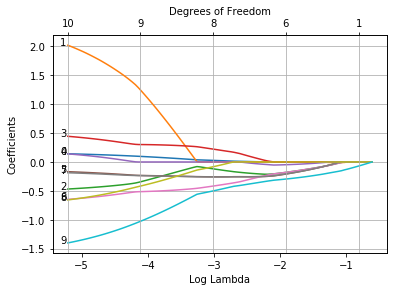

{'ax1': <matplotlib.axes._subplots.AxesSubplot at 0x7ff87dab1208>,
 'ax2': <matplotlib.axes._subplots.AxesSubplot at 0x7ff87d7c9470>,
 'fig': <matplotlib.figure.Figure at 0x7ff886a21470>}

In [11]:
glmnetPlot(fit, xvar = 'lambda', label = True)

In [12]:
glmnetPrint(fit)

	 df 	 %dev 	 lambdau

0 	 0.000000 	 0.000000 	 0.546594
1 	 1.000000 	 0.017763 	 0.521751
2 	 1.000000 	 0.034744 	 0.498036
3 	 1.000000 	 0.050955 	 0.475400
4 	 1.000000 	 0.066409 	 0.453792
5 	 1.000000 	 0.081119 	 0.433167
6 	 1.000000 	 0.095102 	 0.413479
7 	 1.000000 	 0.108377 	 0.394685
8 	 1.000000 	 0.120961 	 0.376746
9 	 3.000000 	 0.134949 	 0.359623
10 	 4.000000 	 0.160340 	 0.343277
11 	 6.000000 	 0.196748 	 0.327675
12 	 6.000000 	 0.232734 	 0.312781
13 	 6.000000 	 0.266536 	 0.298565
14 	 7.000000 	 0.298525 	 0.284995
15 	 7.000000 	 0.329096 	 0.272041
16 	 7.000000 	 0.357688 	 0.259677
17 	 6.000000 	 0.384315 	 0.247874
18 	 6.000000 	 0.409098 	 0.236608
19 	 6.000000 	 0.432167 	 0.225853
20 	 6.000000 	 0.453644 	 0.215588
21 	 6.000000 	 0.473616 	 0.205789
22 	 6.000000 	 0.492174 	 0.196436
23 	 6.000000 	 0.509406 	 0.187508
24 	 6.000000 	 0.525396 	 0.178985
25 	 6.000000 	 0.540225 	 0.170850
26 	 6.000000 	 0.553968 	 0.163084
27 	 6.000000 	

In [13]:
glmpred = glmnetPredict(fit, Xscipy, ptype = 'response', s = scipy.float64([0.005466])).reshape(-1)

In [17]:
yscipy

array([ 1.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  1.])

In [35]:
glmpred

array([-0.01617849, -1.00878444, -0.63113444, -0.74771879, -0.81429673,
       -1.51826523, -1.0419459 , -1.74498552, -0.21840238])

In [36]:
#pp = np.dot(Xscipy, c) + glmnetCoef(fit)[0, -1]
#np.sqrt(np.mean(np.square(pp - yscipy)))

1.5489820112856223

In [38]:
pp

array([-0.01618126, -1.00878928, -0.63113765, -0.74772239, -0.81430044,
       -1.51826935, -1.04194957, -1.74499234, -0.21840532])

In [39]:
np.sqrt(np.mean(np.square(glmpred[0] - yscipy)))

0.75749151504117185